# Setup

In [1]:
import pandas as pd
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns

# Bevölkerung Deutschlands
p = 83e6

# Dauer der Infetiosität
d1 = 10

# Dauer der Immunität
d2 = 90

# Neuinfektionen
df1 = pd.read_csv('https://raw.githubusercontent.com/robert-koch-institut/SARS-CoV-2-Nowcasting_und_-R-Schaetzung/main/Nowcast_R_aktuell.csv')
df1 = df1[['Datum', 'PS_COVID_Faelle_ma4']]
df1.rename(inplace=True, columns={'Datum': 'date', 'PS_COVID_Faelle_ma4': 'cases'})

# Impfungen
df2 = pd.read_csv('https://impfdashboard.de/static/data/germany_vaccinations_timeseries_v3.tsv', sep='\t')
df2 = df2[['date', 'impfungen','impfquote_boost1']]
df2.rename(inplace=True, columns={'date': 'date', 'impfungen': 'vaccinations', 'impfquote_boost1': 'boost'})

# Intensivbelegung
df3 = pd.read_csv('https://diviexchange.blob.core.windows.net/%24web/zeitreihe-deutschland.csv')
df3 = df3.loc[df3['Behandlungsgruppe'] == 'ERWACHSENE']
df3 = df3[['Datum', 'Aktuelle_COVID_Faelle_ITS', 'Belegte_Intensivbetten', 'Freie_Intensivbetten']]
df3.rename(inplace=True, columns={'Datum':'date','Aktuelle_COVID_Faelle_ITS':'covid','Belegte_Intensivbetten':'occupied','Freie_Intensivbetten':'free'})
df3.reset_index(drop=True, inplace=True)

# Initial state

In [44]:
t0 = df1.loc[df1['date'] == '2022-09-30'].index[0]

i = sum(df1['cases'][t0-d1:t0]) # infected
r1 = sum(df1['cases'][t0-d2:t0-d1]) # recovered

t0 = df2.loc[df2['date'] == '2022-09-30'].index[0]

r2 = df2['boost'].iloc[t0] # boosted

i *= 2/p
r = r1/p + r2
s = 1 - i - r

print(f"recovered: {r1/p}")
print(f"boosted: {r2}\n")


print(f"group: {'share':<6} | amount")
print(f"s    : {s:<8.3g} | {s*p:.3g}")
print(f"i    : {i:<8.3g} | {i*p:.3g}")
print(f"r    : {r:<8.3g} | {r*p:.3g}")

recovered: 0.05168248192771084
boosted: 0.62146

group: share  | amount
s    : 0.313    | 2.6e+07
i    : 0.0136   | 1.13e+06
r    : 0.673    | 5.59e+07


# Vaccinations

In [45]:
# Durschnittliche tägliche Impfungen 2022
t0 = df2.loc[df2['date'] == '2022-01-01'].index[0]
t1 = df2.loc[df2['date'] == '2022-09-30'].index[0]

v1 = st.mean(df2['vaccinations'][t0:t1])

# Maximale täglicheImpfungen
v2 = df2['vaccinations'].iloc[df2['vaccinations'].idxmax()]

print(f"average year   : {v1/p:<6.2g} | {v1:>.0f}")
print(f"maximum        : {v2/p:<6.2g} | {v2:>.0f}")

average year   : 0.0014 | 117005
maximum        : 0.019  | 1561544


# Health System

In [7]:
# Maximale Anzahl von gleichzeitig auf der Intensivstation behandelten Covid-19 Patienten
icu_max = df3['covid'].iloc[df3['covid'].idxmax()]
# Maximale Anzahl von gleichzeitig mit Covid-19 Infizierten
i_max = icu_max / 0.003 / 0.13

print(f"date: {df3['date'].iloc[df3['covid'].idxmax()]}")
print(f"maximum of icu covid patients  : {icu_max:>.3g}")
print(f"maximum of infected individuals: {i_max:>.3g}")

date: 2021-01-03T12:15:00+01:00
maximum of icu covid patients  : 5.74e+03
maximum of infected individuals: 1.47e+07


# Plots

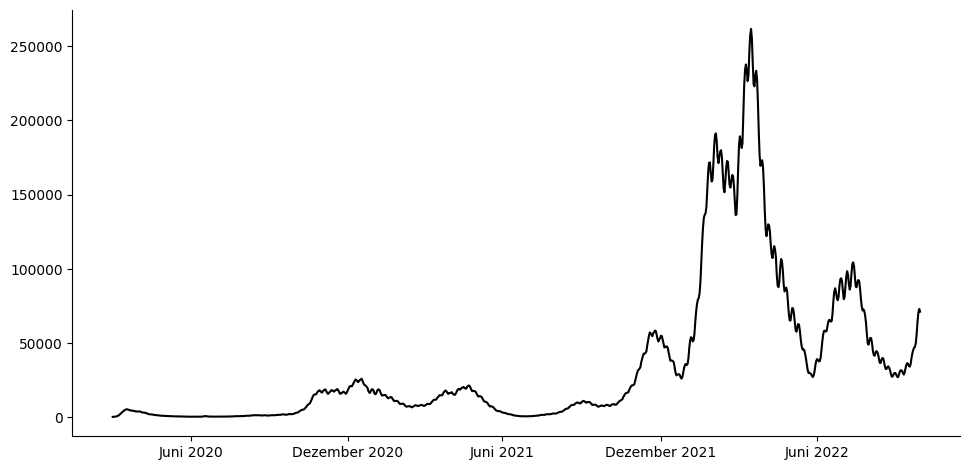

In [24]:
# cases
t0 = df1.loc[df1['date'] == '2022-09-30'].index[0]
c = df1[['cases']][:t0]

sns.relplot(x=c.index, y='cases', data=c, kind='line', color='k', aspect=2)
plt.xlabel('')
plt.ylabel('')
plt.xticks([91,274,454,639,821],['Juni 2020','Dezember 2020','Juni 2021','Dezember 2021','Juni 2022'])
plt.savefig('figures/incidence.pdf')
plt.show()

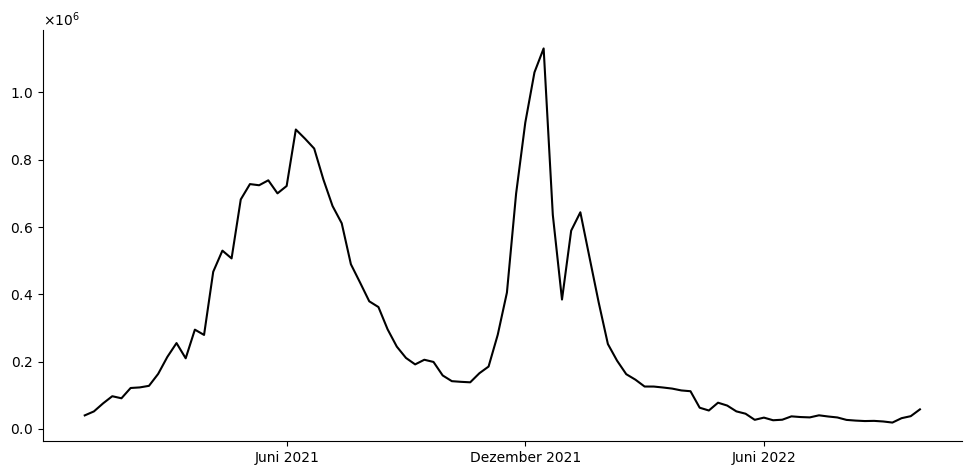

In [26]:
# vaccinations
t0 = df2.loc[df2['date'] == '2022-09-30'].index[0]
v = df2[['vaccinations']][:t0]
v = v.groupby(v.index // 7).mean()

sns.relplot(x=v.index, y='vaccinations', data=v, kind='line', color='k', aspect=2)
plt.ticklabel_format(useMathText=True)
plt.xlabel('')
plt.ylabel('')
plt.xticks([22,48,74],['Juni 2021','Dezember 2021','Juni 2022'])
plt.savefig('figures/vaccination.pdf')
plt.show()

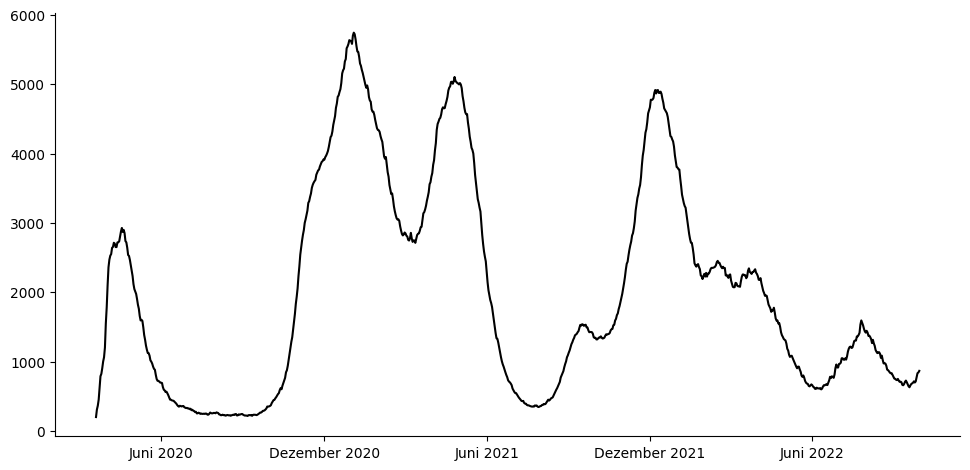

In [49]:
# ICU

t0 = df3.loc[df3['date'].str.contains('2022-09-30')].index[0]
i = df3[['covid']][:t0]

sns.relplot(x=i.index, y='covid', data=i, kind='line', color='k', aspect=2)
plt.xlabel('')
plt.ylabel('')
plt.xticks([73,256,438,621,803],['Juni 2020','Dezember 2020','Juni 2021','Dezember 2021','Juni 2022'])
plt.savefig('figures/icu.pdf')
plt.show()